# PipeTorch

PipeTorch is a library to simplify predictive analytics experiments using SKLearn, PyTorch, Pandas. Although these libraries provide great support for the 'core business' of predictive analytics, for experiments you often have to write quite a bit of additional code to prepare data, create an evaluation report, optimize your models, etc. Between experiments, the additional code that is needed is often repetitive. This means that coding experiments is not as efficient as it could be, and that the code between models that are compared might become inconsistent. 

The idea behind PipeTorch is to support the standard workflow of data science experiments. A minimal example can be as efficient as just four lines of code, allowing you to focus on the decisions that matter most instead of coding. Although, ideally we prefer a few more lines to improve readability or to extend the experiment or its analysis.

# Workflow

A simple workflow for a data science project consists of 4 steps:
- [Data](markdown/Data.md): loading, cleaning, visualizing and preparing the dataset. This step transforms the data to a form in which it can readily be processed using SKLearn or PyTorch.
- [Model](markdown/Model.md): this is the least supported step in PipeTorch as we most often use a model from SKLearn or handcode a model in PyTorch. But there are a few easy to use models for PyTorch to create a Perceptron, ConvNet and to do transfer learning.
- [Train](markdown/Train.md): for training and validating models in PyTorch there is a general purpose trainer. There is also support for model/hyperparameter optimization.
- [Evaluate](markdown/Evaluate.md): report and visualize the model performance

We have organized PipeTorch in four modules with those names. Click on the links to get more info on each module. The modular design allows to use PipeTorch  for one or more of these steps, and code the other steps using other libaries.

# Example

We will give an example here with SKlearn, and then one with PyTorch.

In [22]:
from torch import nn                    
from pipetorch.train import *
from pipetorch.data import read_from_kaggle, create_kaggle_authentication
from pipetorch.model import MultiLayerPerceptron_BinaryClass
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Data

In the data module are data loaders, to load data from .csv files, download from kaggle, use text and images. In this example, we will use the 'Wine' dataset from Kaggle https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009, which you can download using the read_from_kaggle function with the `username/datasetname` part from the kaggle url.

Note: if you install PipeTorch on your own machine, you will need to (1) register at Kaggle, (2) create a token and (3) run `create_kaggle_authorization(username, token)` or install the `kaggle.json` file manually into `.kaggle`. Otherwise `read_from_kaggle` will not be authorized and fail.

In [ ]:
# create_kaggle_authentication(username, token)

In [31]:
df = read_from_kaggle('uciml/red-wine-quality-cortez-et-al-2009') 

The data is read as an extended DataFrame. We can use Pandas to select and clean the data. Then for the daa preparation, we can use functions that PipeTorch added to this DataFrame, to `split` the dataset in a 80%-20% train/valid split and to `scale` the variables (by default with a StandardScaler). 

The call to `columny()` is optional, by default PipeTorch will use the last column as target variable and output this as a column vector. Actually, that is how PyTorch likes it, some SKLearn models will throw a warning if you do not pass y as a row vector, and the `vector=True` will give that and thus supress the warning.

In [32]:
df = df[['alcohol', 'pH', 'quality']]
df.quality = df.quality > 5
df = df.split(0.2).scale().columny('quality', vector=True)

The splits are avialable as `df.train` and `df.valid`. You can visualize these subsets with a few `plot` and `scatter` functions. By default, PipeTorch will use the last column as the target variable, which in the scatter2d_class is used as the class label. The first two features will be used on the axis. In the background, matplotlib is used and any argument is passed, so `s=2` will set the size.

Note: the data is only scaled when we prepare the data (e.g. `df.train.X`), therefore the DataFrame and the visualization will still show the original data, which is often easier to understand.

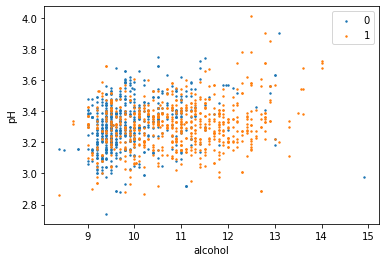

In [33]:
df.train.scatter2d_class(s=2)

# Model

For learning a Logistic Regression model, we simply use SKLearn

In [35]:
model = LogisticRegression()
model.fit(df.train_X, df.train_y)

LogisticRegression()

# Evaluation

To evaluate, we can for example compute metrics like we are used to, or in this case use the supported visualization to show the decision boundary.

In [36]:
valid_y_pred = model.predict(df.valid.X)
f1_score(df.valid.y, valid_y_pred)

0.7305389221556886

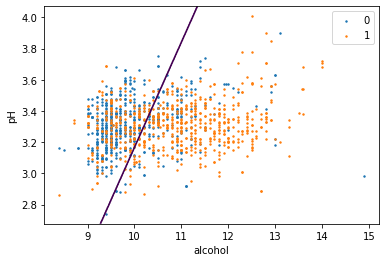

In [37]:
df.train.scatter2d_class(s=2)
df.train.plot_boundary(model.predict)

# Using PyTorch

We can reuse the exact same DataFrame, with the convenience that we also use the exact same data split and scaling. Thus, the results become comparable. The main difference is that for PyTorch, we require Datasets or DataLoaders. There are several options, the fastest one is to convert the DataFrame into a `DataBunch`, an object which wraps a `.train_dl` and `.valid_dl` DataLoader, and the PipeTorch Trainer will know what to do with it.

In [44]:
db = df.columny(vector=False).to_databunch()

# Model

You can of course write your own model in PyTorch, but PipeTorch model also has some models built in. In this case we create a single layer perceptron with a Sigmoid (Logistic function) on the output layer. This is in fact the neural network equivalent of logistic regression, therefore we should get the same result. The input (2) has to match the number of input features, the output (1) has to match the number of output features.

In [85]:
model = MultiLayerPerceptron_BinaryClass(2, 1)

In [86]:
model

MultiLayerPerceptron_BinaryClass(
  (w1): Linear(in_features=2, out_features=1, bias=True)
  (activation1): Sigmoid()
)

# Train

PipeTorch has a general purpose Trainer, that is easy to use and provides enough functionality for most experiments. You will hve to instantiate it with the model, loss function, databunch (or dataloaders) and optionally the metrics you wish to evaluate.

To train a model, you can provide the number of epochs, cycle (after every cycle the validation set is run, therefore a higher cycle reduces the output) and learning rate. The reported f1_score is over the validation set, but the scores over the train set are also stored.

In [87]:
t = Trainer(model, nn.BCELoss(), db, metrics=f1_score)

In [89]:
t.train(100, lr=1e-3, cycle=10)

Total:   0%|          | 0/131200 [00:00<?, ?it/s]

110 0.32s trainloss=0.58200 validloss=0.56092 f1_score=0.73054 
120 0.31s trainloss=0.58199 validloss=0.56080 f1_score=0.73054 
130 0.31s trainloss=0.58200 validloss=0.56069 f1_score=0.73433 
140 0.31s trainloss=0.58196 validloss=0.56061 f1_score=0.73054 
150 0.31s trainloss=0.58200 validloss=0.56072 f1_score=0.73054 
160 0.31s trainloss=0.58194 validloss=0.56062 f1_score=0.73054 
170 0.31s trainloss=0.58203 validloss=0.56068 f1_score=0.73054 
180 0.32s trainloss=0.58197 validloss=0.56066 f1_score=0.73054 
190 0.32s trainloss=0.58197 validloss=0.56055 f1_score=0.73054 
200 0.31s trainloss=0.58197 validloss=0.56069 f1_score=0.73054 


The trainer also provides easy ways to diagnose learning and validate the model.

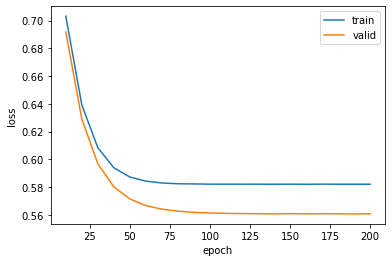

In [90]:
t.learning_curve()

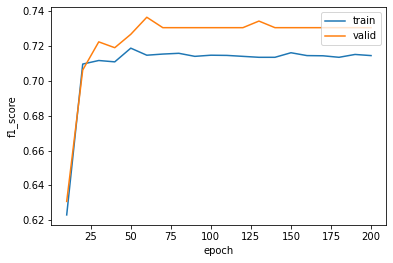

In [91]:
t.validation_curve()

# Evaluation

We can run the evaluation the same way. From the DataBunch, `.valid_X` will prepare the data as a PyTorch Tensor and we need to convert the class likelihood to a class label using `torch.round`. 

In [94]:
valid_y_pred = torch.round(model(db.valid_X))
f1_score(df.valid.y, valid_y_pred)

0.7305389221556886

The visualization also works with a PyTorch model.

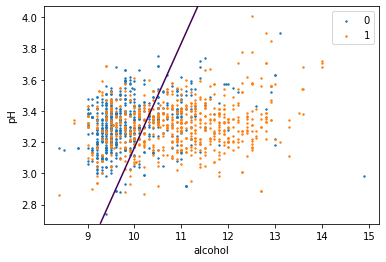

In [95]:
df.train.scatter2d_class(s=2)
df.train.plot_boundary(model)